## Test the pretrained model's predictions on some noisy voices.

We are using this model: https://github.com/vbelz/Speech-enhancement

In [1]:
# constants (defined in the repo)
SAMPLE_RATE = 8000
MIN_DURATION = 1.0
FRAME_LENGTH = 8064
HOP_LENGTH_FRAME = 8064
HOP_LENGTH_FRAME_NOISE = 5000
N_FFT = 255
HOP_LENGTH_FFT = 63
DIM_SQUARE_SPEC = int(N_FFT / 2) + 1

In [2]:
from IPython import display
example_audio = "D:/for-norm/training/real/file1.wav_16k.wav_norm.wav_mono.wav_silence.wav"
display.display(display.Audio(example_audio, rate=SAMPLE_RATE))

In [3]:
import librosa
waveform, _ = librosa.load(example_audio, sr=SAMPLE_RATE)
waveform.shape

(20013,)

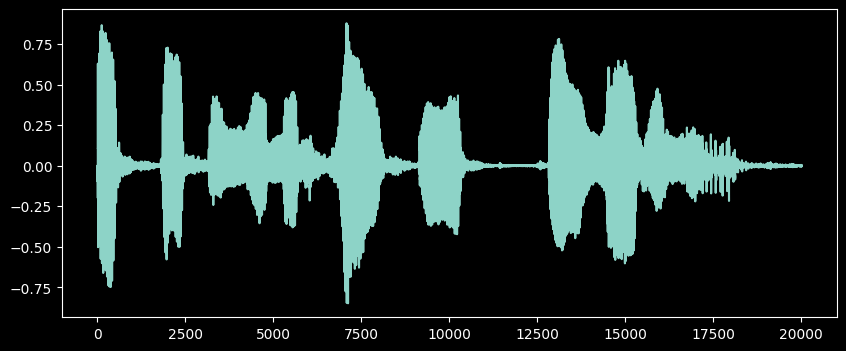

In [4]:
import matplotlib.pyplot as plt
plt.style.use("dark_background")
plt.figure(figsize=(10, 4))
plt.plot(waveform)
plt.show()

In [5]:
with open("weights/model_unet.json", "r") as json_file:
    loaded_model_json = json_file.read()

In [6]:
import tensorflow as tf
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
loaded_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_48 (Conv2D)             (None, 128, 128, 16  160         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_46 (LeakyReLU)     (None, 128, 128, 16  0           ['conv2d_48[0][0]']              
                                )                                                           

In [7]:
import denoising_AE as DAE

In [8]:
# loading audio with my function
audio = DAE.single_audio_file_to_numpy(example_audio, SAMPLE_RATE, FRAME_LENGTH, HOP_LENGTH_FRAME, MIN_DURATION)
audio.shape

(2, 8064)

In [9]:
# loading audio as authors did (prob a better idea)
# start by predicting on training data, we can evaluate on validation/test later
real_audio_dir_prediction = "D:/for-norm/training/real"; fake_audio_dir_prediction = "D:/for-norm/training/fake"
real_audio_prediction = "file1.wav_16k.wav_norm.wav_mono.wav_silence.wav"; fake_audio_prediction = "file1000.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav"

real_audio = DAE.audio_files_to_numpy(real_audio_dir_prediction, real_audio_prediction, SAMPLE_RATE, FRAME_LENGTH, HOP_LENGTH_FRAME, MIN_DURATION)
fake_audio = DAE.audio_files_to_numpy(fake_audio_dir_prediction, fake_audio_prediction, SAMPLE_RATE, FRAME_LENGTH, HOP_LENGTH_FRAME, MIN_DURATION)

real_audio.shape, fake_audio.shape # the first fake example is short so the preprocessing will cut it off

((2, 8064), (1, 0))

In [10]:
m_amp_db_audio, m_pha_audio = DAE.numpy_audio_to_matrix_spectrogram(real_audio, DIM_SQUARE_SPEC, N_FFT, HOP_LENGTH_FFT)
m_amp_db_audio.shape, m_pha_audio.shape

((2, 128, 128), (2, 128, 128))

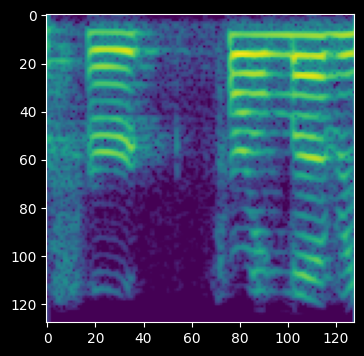

In [16]:
plt.figure(figsize=(10, 4))
plt.imshow(m_amp_db_audio[1])

In [17]:
# global scaling to have distribution -1/1
X_in = DAE.scaled_in(m_amp_db_audio)
#Reshape for prediction
X_in = X_in.reshape(X_in.shape[0],X_in.shape[1],X_in.shape[2],1)
#Prediction using loaded network
X_pred = loaded_model.predict(X_in)

#Rescale back the noise model
inv_sca_X_pred = DAE.inv_scaled_ou(X_pred)
#Remove noise model from noisy speech
X_denoise = m_amp_db_audio - inv_sca_X_pred[:,:,:,0]
#Reconstruct audio from denoised spectrogram and phase
audio_denoise_recons = DAE.matrix_spectrogram_to_numpy_audio(X_denoise, m_pha_audio, FRAME_LENGTH, HOP_LENGTH_FFT)
#Number of frames
nb_samples = audio_denoise_recons.shape[0]

1/1 [==============================] - 1s 1s/step


In [18]:
audio_denoise_recons.shape

(2, 8064)

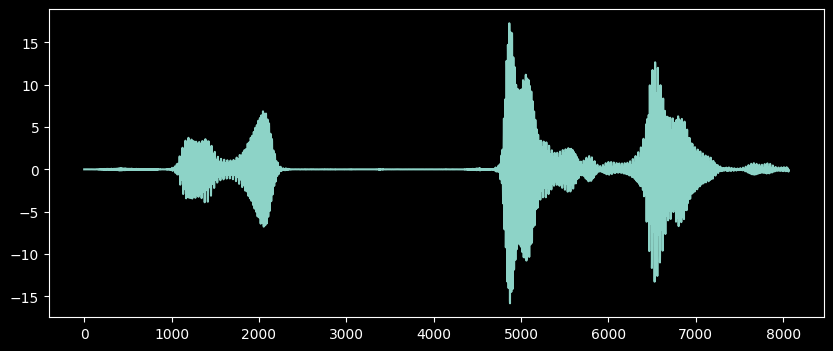

In [22]:
plt.figure(figsize=(10, 4))
plt.plot(audio_denoise_recons[1])
plt.show()

In [23]:
display.display(display.Audio(audio_denoise_recons[1], rate=SAMPLE_RATE))

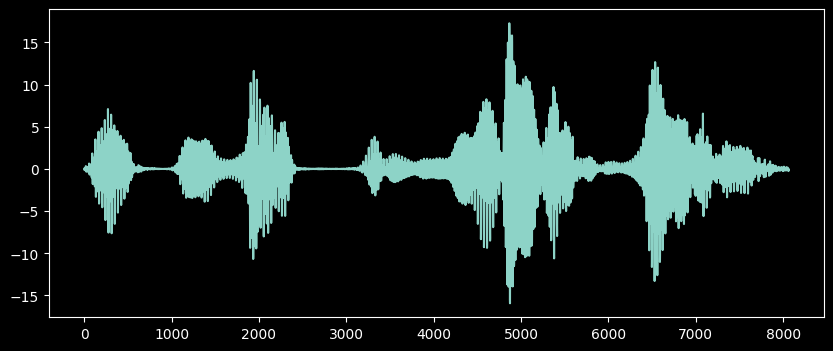

In [24]:
recons_sum = audio_denoise_recons[0] + audio_denoise_recons[1]
plt.figure(figsize=(10, 4))
plt.plot(recons_sum)
plt.show()

In [25]:
display.display(display.Audio(recons_sum, rate=SAMPLE_RATE))

### Let's package all this up into a function.